In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bethe_lattice import bethe_green_function
from mesh import Meshiw, Meshitau
from green_function import Giw, make_Gtau_from_Giw, giw_to_gtau_single
from wc_ctqmc import *

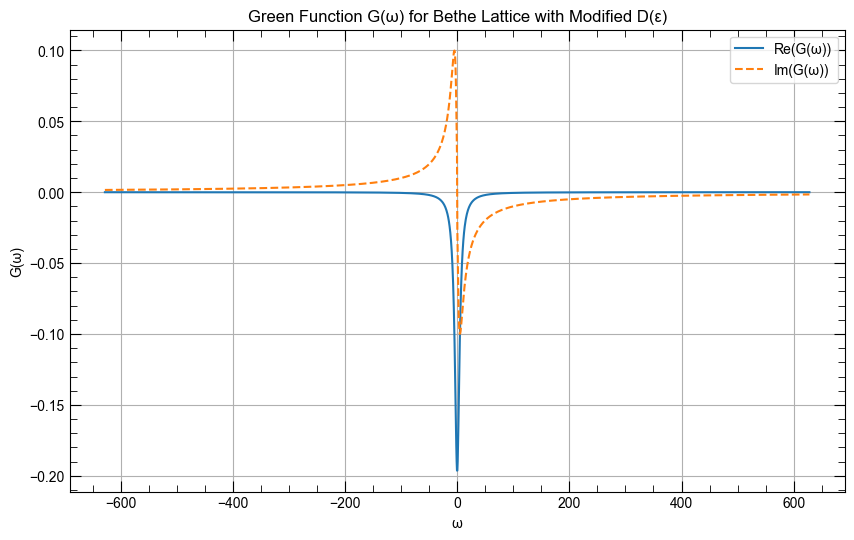

In [2]:
# パラメータの設定
W = 1.0  # 帯域幅
D_0 = 2.0 / np.pi  # 正規化定数 (D_0 = 2/π を仮定)
delta = 0.00  # 正の無限小量
beta = 10  # 逆温度
U = 5  # 相互作用

# マツバラ周波数の定義
meshiw = Meshiw(beta, 1000)

# グリーン関数の計算
giw_values = np.array(
    [bethe_green_function(1.0j * omega, W, D_0, delta) for omega in meshiw.iw]
)
giw_values = 1 / (1 / giw_values - U)
giw = Giw(meshiw, giw_values)

# 結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(giw.meshiw.iw, giw.giw_value.real, label="Re(G(ω))")
plt.plot(giw.meshiw.iw, giw.giw_value.imag, label="Im(G(ω))", linestyle="dashed")
plt.xlabel("ω")
plt.ylabel("G(ω)")
plt.title("Green Function G(ω) for Bethe Lattice with Modified D(ε)")
plt.legend()
plt.grid(True)
plt.show()

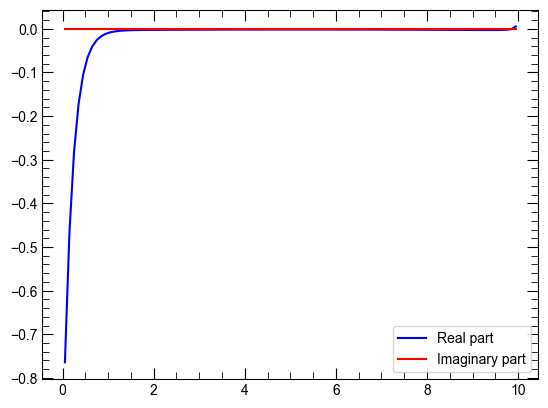

In [3]:
# Gtauへの変換
gtau = make_Gtau_from_Giw(giw, 100)

# プロット (imaginary time)
fig, ax = plt.subplots()
ax.plot(gtau.meshitau.tau, np.real(gtau.gtau_value), "b-", label="Real part")
ax.plot(gtau.meshitau.tau, np.imag(gtau.gtau_value), "r-", label="Imaginary part")
ax.legend()

In [4]:
g0 = lambda tau: giw_to_gtau_single(giw, tau)
C_up = []
C_dn = []
M_inv_up = build_M_inv(C_up, g0, beta)
M_inv_dn = build_M_inv(C_dn, g0, beta)

In [5]:
C_up, C_dn, M_inv_up, M_inv_dn = attempt_vertex_update(
    C_up, C_dn, M_inv_up, M_inv_dn, g0, U, beta
)
print(C_up)

25.143496482738847
[8.051032612493819]


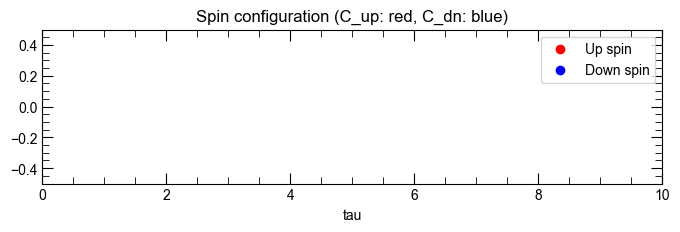

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# g0, U, beta, and other functions (giw_to_gtau_single, build_M_inv, attempt_vertex_update)
# are assumed to be defined already.

# 初期状態
C_up = []
C_dn = []
M_inv_up = build_M_inv(C_up, g0, beta)  # C_upのtauのみでM_inv作成
M_inv_dn = build_M_inv(C_dn, g0, beta)  # C_dnのtauのみでM_inv作成

fig, ax = plt.subplots(figsize=(8, 2))
ax.set_xlim(0, beta)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel("tau")
ax.set_title("Spin configuration (C_up: red, C_dn: blue)")

# 散布図オブジェクト作成
up_scatter = ax.scatter([], [], color="red", marker="o", label="Up spin")
dn_scatter = ax.scatter([], [], color="blue", marker="o", label="Down spin")
ax.legend()


def init():
    # 初期化: 空のデータをセット（0要素でも2D配列）
    up_scatter.set_offsets(np.empty((0, 2)))
    dn_scatter.set_offsets(np.empty((0, 2)))
    return up_scatter, dn_scatter


def update(frame):
    global C_up, C_dn, M_inv_up, M_inv_dn
    # 1ステップ更新
    C_up, C_dn, M_inv_up, M_inv_dn = attempt_vertex_update(
        C_up, C_dn, M_inv_up, M_inv_dn, g0, U, beta
    )

    # C_up, C_dnはtauのみ
    tau_up = C_up
    tau_dn = C_dn

    # アップスピンはy=0.2に、ダウンスピンはy=-0.2にプロット
    if len(tau_up) > 0:
        up_points = np.column_stack((tau_up, [0.2] * len(tau_up)))
        up_scatter.set_offsets(up_points)
    else:
        up_scatter.set_offsets(np.empty((0, 2)))

    if len(tau_dn) > 0:
        dn_points = np.column_stack((tau_dn, [-0.2] * len(tau_dn)))
        dn_scatter.set_offsets(dn_points)
    else:
        dn_scatter.set_offsets(np.empty((0, 2)))

    return up_scatter, dn_scatter


n_steps = 100  # アニメーションフレーム数(更新回数)
anim = FuncAnimation(
    fig, update, frames=n_steps, init_func=init, blit=True, interval=200
)

plt.show()

In [7]:
from IPython.display import HTML

# animはFuncAnimationで生成したアニメーションオブジェクト
HTML(anim.to_jshtml())

25.143496482738847
0.03977171594597059
12.570601315541614
8.380796197507346
0.1193204054165432
6.264428756556906
25.143496482738847
12.571583220965461
0.15912275484581576
0.07954447601574265
0.07954447601574265
5.028400868139874
0.19887038170246835
8.380212160154052
0.15909510039426014
6.274092164078961
5.02831624888637
4.189227511187139
0.23870749376336003
0.23865235834880044
5.027344167235142
0.1989121824038484
0.19954046331381553
0.19892324726186514
0.15938560892128695
0.15912231537244945
0.1596311832217112
5.028094063061863
0.15909416206814708
0.19888251640842397
0.15915220632208646
4.19026146868593
3.589231403975265
0.279360833827171
3.122767016153261
0.32022882105109357
6.285567665089436
0.1593400010999097
3.141079619597764
5.02819658586744
0.31821335850643473
2.7925824512759823
4.166660392084833
2.512834432397727
3.591312309182641
0.28028992802803493
0.2784298656636078
0.24000269299489707
0.2386540573235743
2.2794490552959323
0.4376194045091058
3.58959302953816
2.088641374420687